# Customer Transactions Models **4 Periods, Target 2021-only**<br>ROC-AUC

**by David Cochran**<br/>
**Data Analytics @ Newman University**

**Contents:**
1. Read and Review Data
2. Prepare Data Splits
3. Train Models & Tune Hyperparameters
4. Test & Evaluate Tuned Models
5. View under hood of models

In [ ]:
# Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from time import time

# Libraries for Machine Learning Process
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Customize seaborn plot styles
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook', font_scale = 0.8)
sns.set_style('ticks')
plt.rc('axes.spines', top=False, right=False, left=False, bottom=False)

# 1. Read and Review Data

This data has been cleaned in a previous EDA and preparation process.

In [ ]:
# Read cleaned version of the data
df = pd.read_csv('data/custtranss_4p_t2021.csv', index_col='Customer Id')
df.head(10)

,t2021,ts2018-20,ts2015-17,ts2010-14,ts2009-bf
Customer Id,,,,,
001E000000B7IbwIAF,0,2,5,22,155
0014400001igKBlAAM,0,3,0,31,138
001E000000B7UTkIAN,1,2,12,13,102
001E000000B7R7cIAF,1,3,34,48,33
001E000000B7Mw5IAF,0,0,0,5,105
001E000000kT4zzIAC,1,9,48,27,0
001E000000Djh3FIAR,1,23,29,8,13
001E000000B7LLiIAN,0,5,43,35,22
001E000000WpGMJIA3,1,5,35,38,4


In [ ]:
# Dataframe fundamental info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28368 entries, 001E000000B7IbwIAF to 001E000001Z3rbvIAB
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   t2021      28368 non-null  int64
 1   ts2018-20  28368 non-null  int64
 2   ts2015-17  28368 non-null  int64
 3   ts2010-14  28368 non-null  int64
 4   ts2009-bf  28368 non-null  int64
dtypes: int64(5)
memory usage: 1.3+ MB


## Separate Features from Labels

In [ ]:
# features — all columns except target variable
features = df.drop('t2021', axis=1)

# labels — only the target variable column
labels = df['t2021']

## Check the distribution of target classes

In [ ]:
labels.value_counts()

0    24065
1     4303
Name: t2021, dtype: int64

In [ ]:
labels.value_counts(normalize=True) * 100

0    84.8315
1    15.1685
Name: t2021, dtype: float64

**Our target classes are quite imbalanced.**

The minority class (1) is the value that most interests us.

Thus our models will likely benefit from weighting the minority class to balance the model training process.

These algorithms have a `class_weight` parameter that we can use:
- Logistic Regression
- Decision Tree
- Random Forest

# 2. Prepare Data Splits

In [ ]:
features.head()

,ts2018-20,ts2015-17,ts2010-14,ts2009-bf
Customer Id,,,,
001E000000B7IbwIAF,2,5,22,155
0014400001igKBlAAM,3,0,31,138
001E000000B7UTkIAN,2,12,13,102
001E000000B7R7cIAF,3,34,48,33
001E000000B7Mw5IAF,0,0,5,105


In [ ]:
labels.head()

Customer Id
001E000000B7IbwIAF    0
0014400001igKBlAAM    0
001E000000B7UTkIAN    1
001E000000B7R7cIAF    1
001E000000B7Mw5IAF    0
Name: t2021, dtype: int64

In [ ]:
# Create Train and Test Splits
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Report Number and Proportion of Train and Test Features and Labels
print(f'Train Split: {X_train.shape[0]} Records, {len(y_train)} Labels = {round(len(y_train)/len(labels), 4) * 100}%')
print(f'Test Split: {X_test.shape[0]} Records, {len(y_test)} Labels = {round(len(y_test)/len(labels), 4) * 100}%')

Train Split: 22694 Records, 22694 Labels = 80.0%
Test Split: 5674 Records, 5674 Labels = 20.0%


# 3. Train Models and Tune Hyperparameters

- Train models and using cross-validation with GridSearchCV.
- Prioritize Recall score.

### Set Folds, Priority Score, and Random Seed

In [ ]:
# Specify number of folds for cross-validation
k = 5

# Specify default priority score: accuracy, precision, recall, f1, or roc_auc
priority_score = 'roc_auc'

# Specify random seed value to ensure results are reproducible
seed = 42

### Define Function for Executing and Reporting Cross-Validation

In [ ]:
# Define an empty list to hold our best models
models_tuned = []

# Scorers we desire during training from GridSearchCV
# zero_division=1 eliminates unnecessary UndefinedMetricWarning see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
scoring = {
            'roc_auc': make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=False),
            'recall': make_scorer(recall_score),
            'precision': make_scorer(precision_score, zero_division=1),
            'accuracy': make_scorer(accuracy_score)
            # , 'f1': make_scorer(f1_score, zero_division=1)
          }

# Metrics that we desire for report of GridSearchCV results
metrics = ['params',
           'mean_test_roc_auc',
           'mean_test_recall',
           'mean_test_precision',
           'mean_test_accuracy'
           #, 'mean_test_f1'
          ]


# Define function for cross-validation, reporting, and storing top model to models list
def crossval_func(name, algorithm, hparam_grid, priority_score, k):
    cv = GridSearchCV(
                estimator = algorithm,
                param_grid = hparam_grid, 
                scoring = scoring,
                refit = priority_score, 
                cv = k,
                verbose=1
             )

    # Keep track of training time
    start = time()

    # Activate gridsearch
    cv.fit(X_train, y_train)

    end = time()
    latency = round((end-start), 2)

    # Store top model to models list
    model = cv.best_estimator_
    hparams = cv.best_params_
    score = round(cv.best_score_ * 100, 3)
    models_tuned.append({'Name': name, 'Hparams': hparams, 'Model': model, 'Priority': priority_score, 'Score': score})
    
    # Create dataframe from gridsearch cv_results_
    cv_results = pd.DataFrame.from_dict(cv.cv_results_)

    # Specify desired data from our results dataframe
    # cv_results_metrics = cv_results.loc[:, metrics]
    cv_results_metrics = cv_results[metrics].copy()

    #  Sort values and reset index
    sortby = 'mean_test_' + priority_score
    cv_results_metrics.sort_values(sortby, ascending=False, inplace=True)

    # Set new index starting at 1 for sorted dataframe
    cv_results_metrics.index = range(1, cv_results_metrics.shape[0] + 1)

    # Report results
    print(f'Training Time: {latency}s')
    
    
    print(f'\n{name} CROSS-VALIDATION RESULTS')
    howmany = 1
    print(f'Tuned for {sortby} in cross-validation:')
    display(cv_results_metrics.head(howmany))  
    print('Topmost model added to list of models for testing:')
    print(f'\t{cv.best_estimator_}\n')

## Logistic Regression

In [ ]:
# Specify Algorithm shortname
name = 'Logistic Regression'

# Specify algorithm with desired default hyperparameters
algorithm = LogisticRegression(random_state=seed, fit_intercept=False, max_iter=500, n_jobs=-1)

# Hyperparameter options for GridSearch to test and identify best hyperparameters combination
hparam_grid = {
    'C': [.001, .01, 1, 10, 100, 1000]
}

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, hparam_grid, priority_score, k)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Training Time: 6.09s

Logistic Regression CROSS-VALIDATION RESULTS
Tuned for mean_test_roc_auc in cross-validation:


,params,mean_test_roc_auc,mean_test_recall,mean_test_precision,mean_test_accuracy
1,{'C': 0.01},0.512488,0.028043,0.62122,0.849255


Topmost model added to list of models for testing:
	LogisticRegression(C=0.01, fit_intercept=False, max_iter=500, n_jobs=-1,
                   random_state=42)



## Logistic Regression Balanced

In [ ]:
# Specify Algorithm shortname
name = 'Logistic Regression Balanced'

# Specify algorithm with desired default parameters
algorithm = LogisticRegression(class_weight='balanced', random_state=seed, fit_intercept=False, max_iter=500, n_jobs=-1)

# Hyperparameter options for GridSearch to test and identify best hyperparameters combination
hparam_grid = {
    'C': [.001, .01, 1, 10, 100, 1000]
}

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, hparam_grid, priority_score, k)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Training Time: 1.41s

Logistic Regression Balanced CROSS-VALIDATION RESULTS
Tuned for mean_test_roc_auc in cross-validation:


,params,mean_test_roc_auc,mean_test_recall,mean_test_precision,mean_test_accuracy
1,{'C': 1},0.405356,0.317445,0.102274,0.466466


Topmost model added to list of models for testing:
	LogisticRegression(C=1, class_weight='balanced', fit_intercept=False,
                   max_iter=500, n_jobs=-1, random_state=42)



## Decision Tree Classifier

In [ ]:
# Specify Algorithm shortname
name = 'Decision Tree'

# Specify algorithm with desired default parameters
algorithm = DecisionTreeClassifier(random_state=seed)

# Hyperparameter options for GridSearch to test 
# and identify best hyperparameters combination
hparam_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,5,10],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [2,3,5]
}

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, hparam_grid, priority_score, k)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Training Time: 3.57s

Decision Tree CROSS-VALIDATION RESULTS
Tuned for mean_test_roc_auc in cross-validation:


,params,mean_test_roc_auc,mean_test_recall,mean_test_precision,mean_test_accuracy
1,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.768143,0.548711,0.888272,0.920684


Topmost model added to list of models for testing:
	DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3,
                       min_samples_split=10, random_state=42)



## Decision Tree Balanced

In [ ]:
# Specify Algorithm shortname
name = 'Decision Tree Balanced'

# Specify algorithm with desired default parameters
algorithm = DecisionTreeClassifier(class_weight='balanced', random_state=seed)

# Hyperparameter options for GridSearch to test and identify best hyperparameters combination
hparam_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,5,10],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [2,3,5]
}

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, hparam_grid, priority_score, k)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Training Time: 4.56s

Decision Tree Balanced CROSS-VALIDATION RESULTS
Tuned for mean_test_roc_auc in cross-validation:


,params,mean_test_roc_auc,mean_test_recall,mean_test_precision,mean_test_accuracy
1,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.786252,0.659429,0.579236,0.874417


Topmost model added to list of models for testing:
	DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=3,
                       random_state=42)



## Random Forest Classifier

In [ ]:
# Specify Algorithm shortname
name = 'Random Forest'

# Specify algorithm with desired default parameters
algorithm = RandomForestClassifier(random_state=seed)

# Hyperparameter options for GridSearch to test and identify best hyperparameters combination
hparam_grid = {
    'max_depth': [2, 4, 8, 16, 32, None],
    'n_estimators': [5, 50, 250]
}

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, hparam_grid, priority_score, k)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Training Time: 37.15s

Random Forest CROSS-VALIDATION RESULTS
Tuned for mean_test_roc_auc in cross-validation:


,params,mean_test_roc_auc,mean_test_recall,mean_test_precision,mean_test_accuracy
1,"{'max_depth': 16, 'n_estimators': 50}",0.768531,0.550734,0.878955,0.919935


Topmost model added to list of models for testing:
	RandomForestClassifier(max_depth=16, n_estimators=50, random_state=42)



## Random Forest Balanced

In [ ]:
# Specify Algorithm shortname
name = 'Random Forest Balanced'

# Specify algorithm with desired default parameters
algorithm = RandomForestClassifier(class_weight='balanced', random_state=seed)

# Hyperparameter options for GridSearch to test and identify best hyperparameters combination
hparam_grid = {
    'max_depth': [2, 4, 8, 16, 32, None],
    'n_estimators': [5, 50, 250]
}

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, hparam_grid, priority_score, k)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Training Time: 36.08s

Random Forest Balanced CROSS-VALIDATION RESULTS
Tuned for mean_test_roc_auc in cross-validation:


,params,mean_test_roc_auc,mean_test_recall,mean_test_precision,mean_test_accuracy
1,"{'max_depth': 4, 'n_estimators': 250}",0.787002,0.624745,0.690259,0.899797


Topmost model added to list of models for testing:
	RandomForestClassifier(class_weight='balanced', max_depth=4, n_estimators=250,
                       random_state=42)



## Gradient Boosting Classifier

In [ ]:
# Specify Algorithm shortname
name = 'Gradient Boosting'

# Specify algorithm with desired default parameters
algorithm = GradientBoostingClassifier(random_state=seed)

# Hyperparameter options for GridSearch to test and identify best hyperparameters combination
hparam_grid = {
    'max_depth': [5, 50, 250, 500],
    'n_estimators': [1, 3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 1, 10, 100]
}

# Execute cross validation, report results, and store top model to models list
crossval_func(name, algorithm, hparam_grid, priority_score, k)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Training Time: 38.4s

Gradient Boosting CROSS-VALIDATION RESULTS
Tuned for mean_test_roc_auc in cross-validation:


,params,mean_test_roc_auc,mean_test_recall,mean_test_precision,mean_test_accuracy
1,"{'learning_rate': 100, 'max_depth': 5, 'n_esti...",0.785627,0.656827,0.582612,0.875166


Topmost model added to list of models for testing:
	GradientBoostingClassifier(learning_rate=100, max_depth=5, n_estimators=1,
                           random_state=42)



# 4. Test & Evaluate Tuned Models

In [ ]:
# Function for generating model scores and confusion matrices with custom colors and descriptive labels

def report_scores_enhanced(model):
    '''
    Generate model scores and enhanced confusion matrices
    '''
    y_pred = model['Model'].predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred) * 100
    accuracy = accuracy_score(y_test, y_pred) * 100
#    f1 = f1_score(y_test, y_pred) * 100


    cm = confusion_matrix(y_test, y_pred)
    cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
    cm_colors = sns.color_palette(['gainsboro', 'cornflowerblue'])

    # axis labels for the confusion matrix plot
    cm_y_labels = ['0','1'] # column labels
    cm_x_labels = ['0','1'] # row labels
    
    # Confusion matrix labels
    # Review and update to match the appropriate labels for your data set
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm_norm.flatten()]
    group_labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_counts, group_names, group_percentages)]
    group_labels = np.asarray(group_labels).reshape(2,2)

    # Begin plot setup
    fig, ax = plt.subplots(figsize=(4.2, 4.2))

    # Heatmap
    sns.heatmap(np.eye(2), annot=group_labels, annot_kws={'size': 11}, fmt='', 
                cmap=cm_colors, cbar=False,
                yticklabels=cm_y_labels, xticklabels=cm_x_labels, ax=ax)
    
    # Axis elements
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(labelsize=10, length=0)
    ax.set_xlabel('Predicted Values', size=10)
    ax.set_ylabel('Actual Values', size=10)
    
    # Position group labels and set colors
    for text_elt, group_label in zip(ax.texts, group_labels):
        ax.text(*text_elt.get_position(), '\n', color=text_elt.get_color(),
                ha='center', va='top')

    # Title for each plot
    # Adjust pad to provide room for the score report below title and above confusion matrix plot
    plt.title(f'{model["Name"]}', pad=100, loc='left', fontsize=12, fontweight='bold')

    # Score reports beneath each title
    # Adjust x and y to fit report -- try 0.74 for the y if you activate F1 and AUC
    (
        plt.figtext(0.21, 0.74,
                    f'ROC-AUC: {round(auc, 3)}\n'
                    + f'Recall:  {round(recall,3)}%\n'
                    + f'Precision:  {round(precision, 3)}%\n' 
                    + f'Accuracy:  {round(accuracy, 3)}%\n'
                    # + f'F1: {round(f1, 2)}%\n'
                    , 
                    wrap=True, ha='left', fontsize=10)
    )

    # Display the plot!
    plt.tight_layout()
    plt.subplots_adjust(left=0.2)
    print('\n') # Add a blank line for improved spacing
    plt.show()
    
# =========================================
# List scores ranked by priority score
# =========================================

# List to hold scores for each model
scoreslist = []

scorenames = [
              'ROC-AUC',
              'Recall',
              'Precision',
              'Accuracy'
              #, 'F1 Score'
             ]

# Define function to record and report scores
def record_scores(name, model, features, labels):
    '''
    name = model name
    model = model variable
    features = features of desired split
    labels = labels of desired split
    '''
    predictions = model.predict(features)

    scores = [
              round(roc_auc_score(labels, predictions), 3),
              round(recall_score(labels, predictions) * 100, 3),
              round(precision_score(labels, predictions) * 100, 3),
              round(accuracy_score(labels, predictions) * 100, 3)
              #, f1_score(labels, predictions)
             ]

    
    # Create list with model name, model, and scores
    modelscores = []
    modelscores.append(name)
    for score in scores:
        modelscores.append(score)

    scoreslist.append(modelscores)

# Define function to score all models and report results
def score_models(models_list, features, labels, priority='Accuracy'):
    # Score all models with test split
    for model in models_list:
        record_scores(model['Name'], model['Model'], features, labels)

    # Store to dataframe, including melted version of dataframe for visualization
    tsdf = pd.DataFrame(scoreslist, columns = ['Model'] + scorenames)
    tsdf = tsdf.sort_values(priority, ascending=False).copy()
    tsdf_melt = pd.melt(tsdf, id_vars="Model", var_name="Metric", value_name="Score")
    tsdf_melt
    tsdf.set_index('Model', inplace=True)

    # Display the dataframe
    print(f"\nModel scores ranked by {priority}:")
    display(tsdf)

## Model Scores Ranked by Priority Score

In [ ]:
# View model scores ranked by priority score
score_models(models_tuned, X_test, y_test, priority='ROC-AUC')


Model scores ranked by ROC-AUC:


,ROC-AUC,Recall,Precision,Accuracy
Model,,,,
Decision Tree Balanced,0.783,65.047,57.247,87.575
Random Forest Balanced,0.783,62.204,65.955,89.602
Gradient Boosting,0.781,64.692,57.353,87.593
Random Forest,0.766,54.621,87.476,92.087
Decision Tree,0.765,54.384,87.595,92.069
Logistic Regression,0.516,3.555,68.182,85.407
Logistic Regression Balanced,0.399,34.360,9.904,43.743


## Model Scores with Confusion Matrices

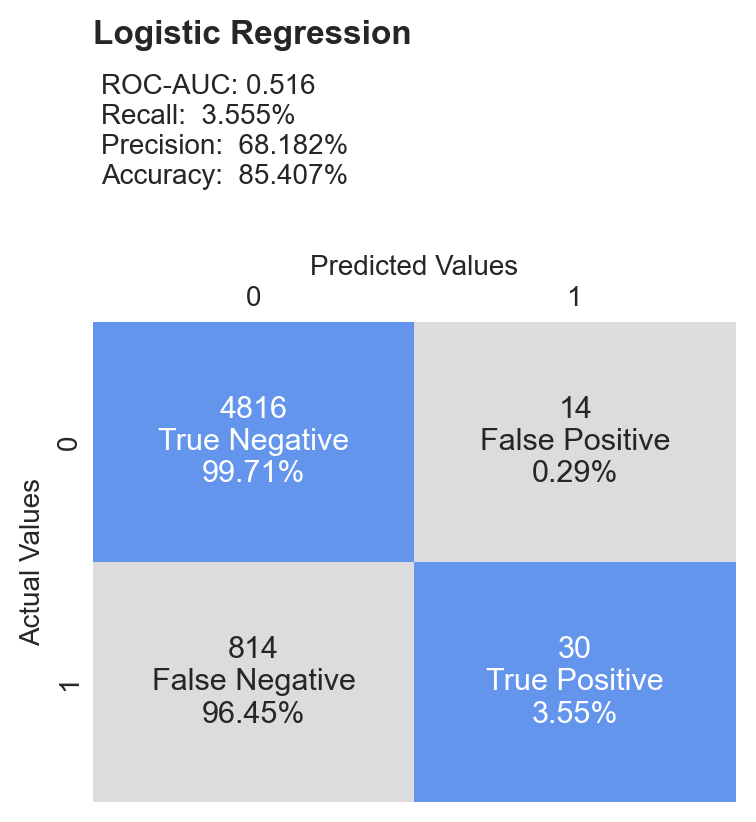

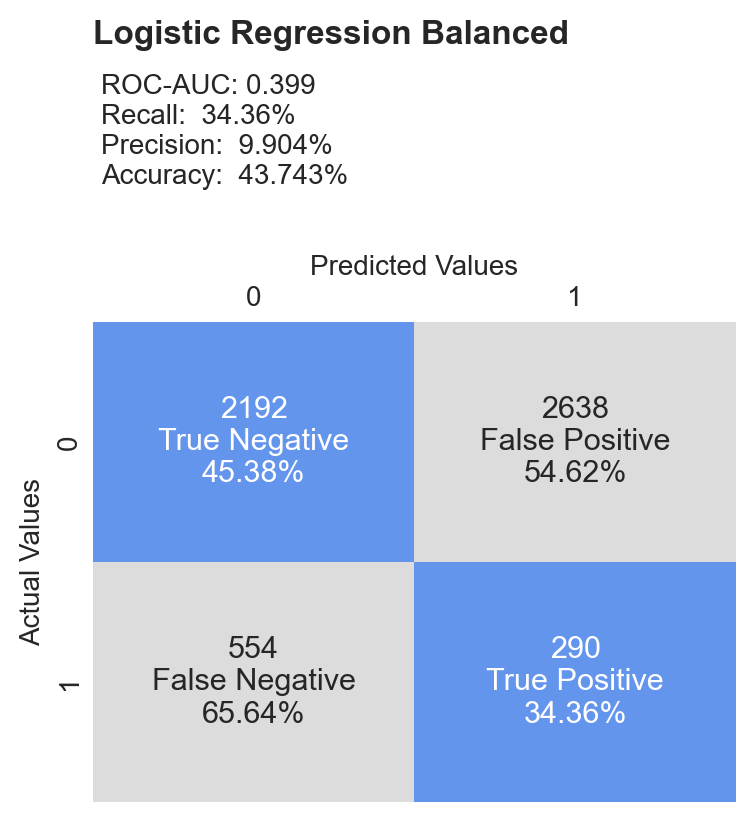

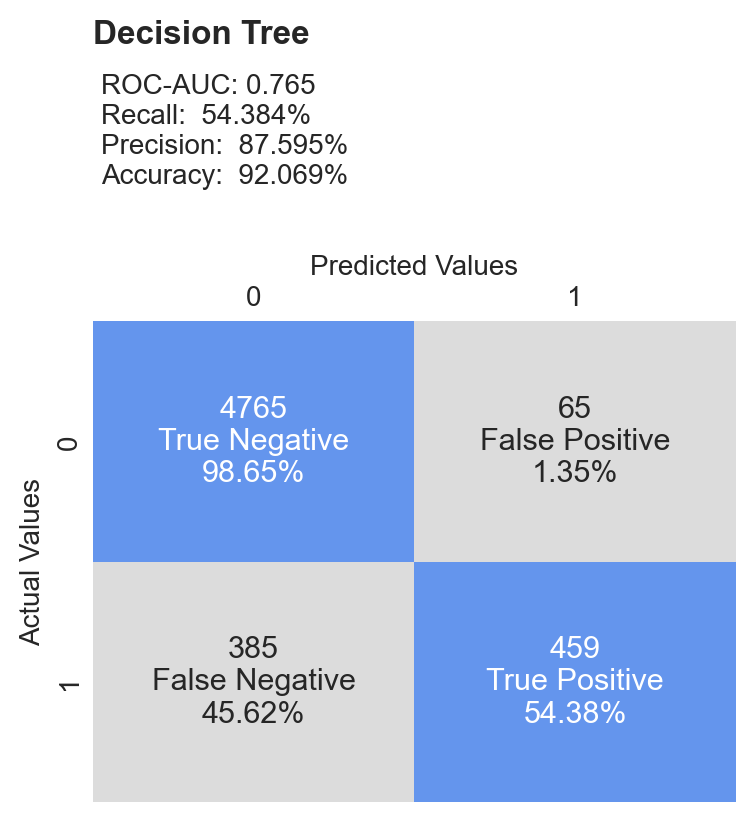

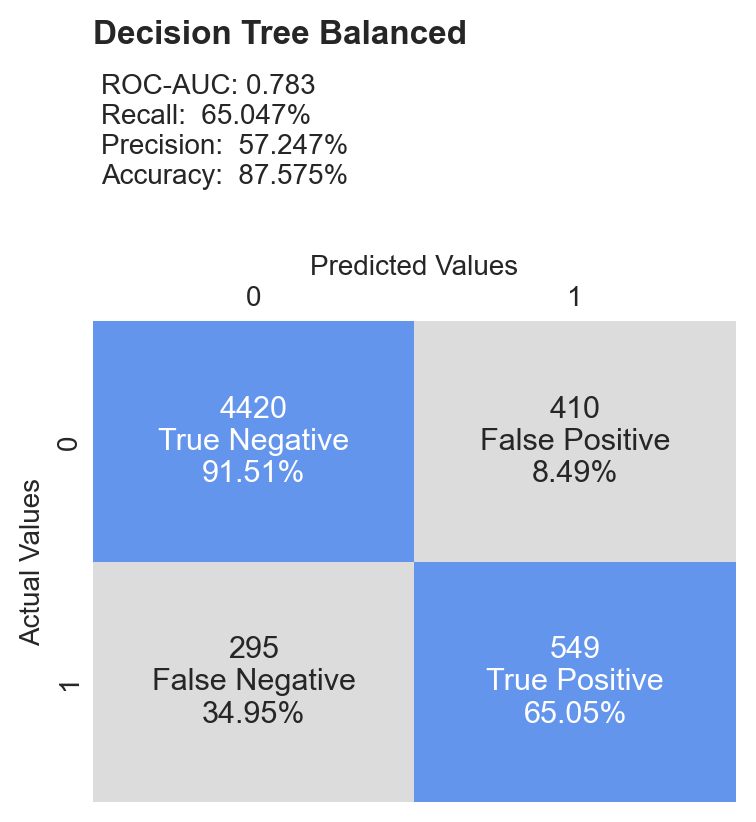

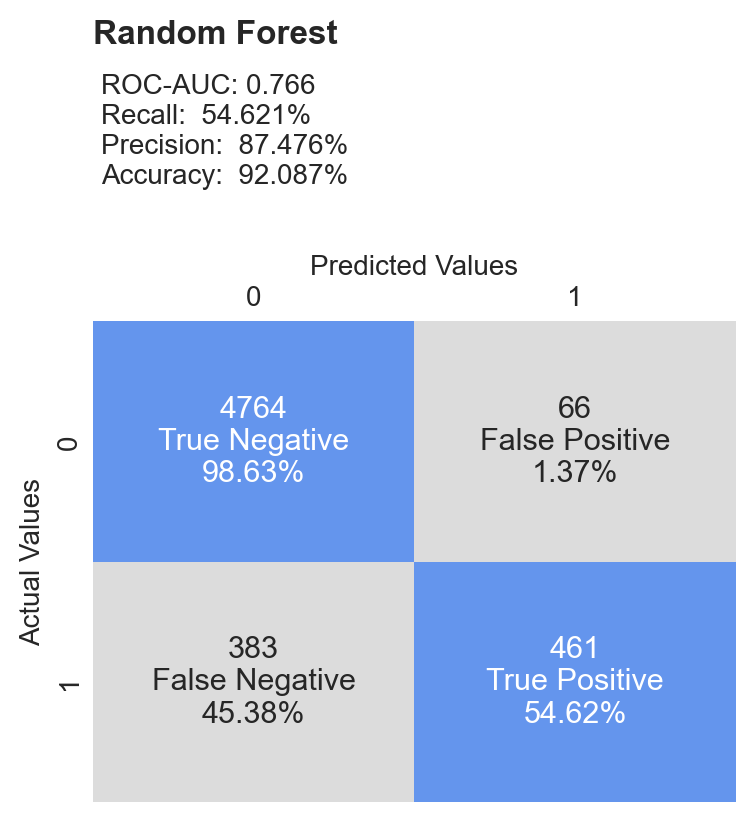

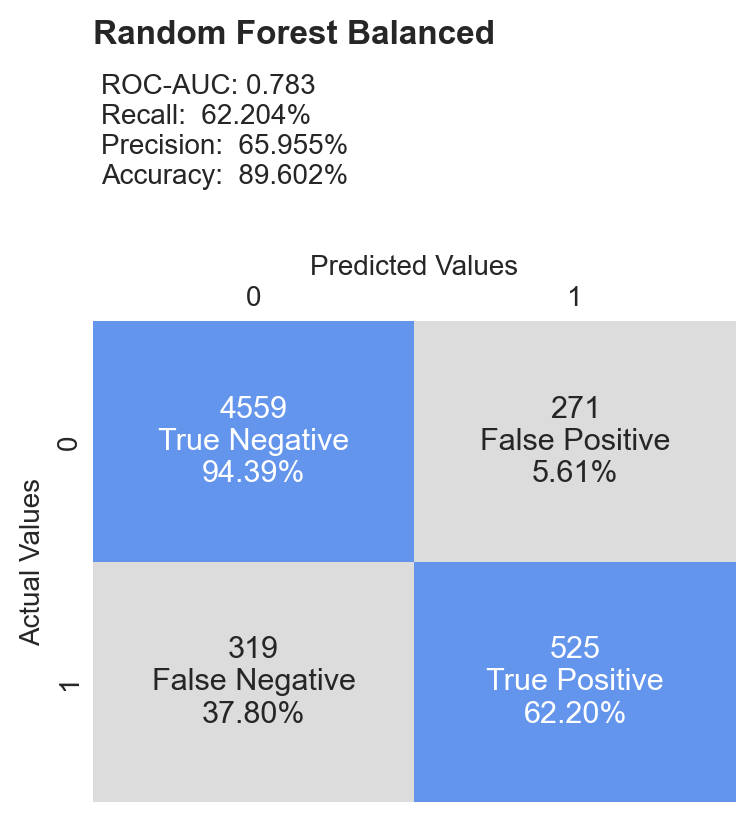

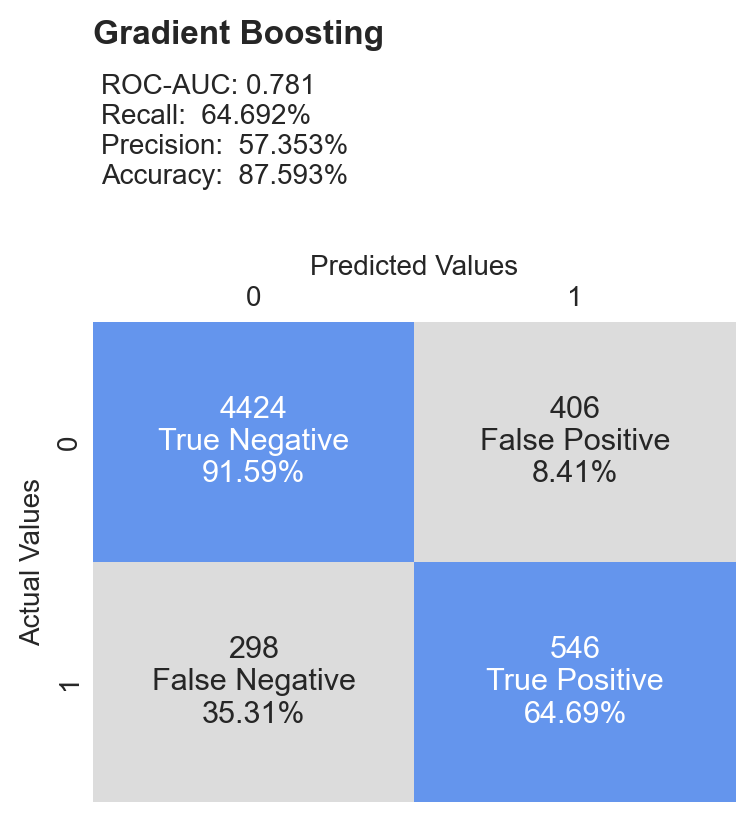

In [ ]:
for model in models_tuned:
    report_scores_enhanced(model)